## __Load Data__

In [1]:
import sys
import os
import numpy as np
import math
import pandas as pd
from ast import literal_eval
from mplsoccer import Pitch, VerticalPitch, Standardizer
# Run the notebook from inside the notebooks folder
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))
from scripts.dataloader import Dataloader


PI = math.pi

dataloader = Dataloader(league="bundesliga")
dataloader.load_data()
df = dataloader.get_dimension(dimension="passing")
df.columns

# load standard stats
standard_stats = pd.read_csv("../../data/standard_stats.csv").loc[:,["player","full_match_equivalents"]]

[2025-05-21 13:11:56] Loading data form local file system


## __Setting types__

In [2]:
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list)
df["pass_end_location"] = df["pass_end_location"].apply(convert_to_list)
df[["x", "y"]] = df["location"].apply(pd.Series)
df[["x_end_pass", "y_end_pass"]] = df["pass_end_location"].apply(pd.Series)

df["under_pressure"] = df["under_pressure"].fillna(False)
df

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_recipient_id,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,x,y,x_end_pass,y_end_pass
6,Mark Uth,"[61.0, 40.1]",False,<NA>,-1.919567,<NA>,Left Foot,<NA>,<NA>,<NA>,...,5460.0,<NA>,NaN,<NA>,Kick Off,NaN,61.0,40.1,60.2,37.9
7,Andrej Kramarić,"[59.4, 38.3]",False,<NA>,2.536994,<NA>,Left Foot,<NA>,<NA>,<NA>,...,6039.0,<NA>,NaN,<NA>,NaN,NaN,59.4,38.3,53.9,42.1
8,Sebastian Rudy,"[52.3, 45.2]",False,<NA>,2.390664,<NA>,Right Foot,<NA>,<NA>,<NA>,...,5537.0,<NA>,NaN,<NA>,NaN,NaN,52.3,45.2,34.3,62.0
9,Fabian Lukas Schär,"[34.3, 61.9]",False,<NA>,-1.487222,<NA>,Right Foot,<NA>,<NA>,<NA>,...,12321.0,<NA>,NaN,<NA>,NaN,NaN,34.3,61.9,37.5,23.7
10,Tobias Strobl,"[38.5, 22.2]",False,<NA>,1.705317,<NA>,Right Foot,<NA>,<NA>,<NA>,...,9396.0,<NA>,NaN,<NA>,NaN,NaN,38.5,22.2,36.7,35.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067213,Mario Götze,"[84.1, 32.2]",False,<NA>,1.710505,<NA>,Right Foot,<NA>,<NA>,<NA>,...,5837.0,<NA>,NaN,<NA>,Recovery,NaN,84.1,32.2,83.2,38.6
1067214,Douglas Costa de Souza,"[86.1, 41.3]",True,<NA>,0.819867,d88c75fa-08a5-4618-b3c2-f92292a6a559,Left Foot,<NA>,<NA>,<NA>,...,5578.0,<NA>,NaN,<NA>,NaN,NaN,86.1,41.3,90.3,45.8
1067215,René Adler,"[7.0, 36.1]",False,<NA>,-0.005102,<NA>,Right Foot,<NA>,<NA>,<NA>,...,8895.0,<NA>,NaN,<NA>,Goal Kick,NaN,7.0,36.1,85.4,35.7
1067216,Jérôme Boateng,"[34.7, 44.4]",False,<NA>,-2.840672,<NA>,Right Foot,<NA>,<NA>,<NA>,...,5570.0,<NA>,NaN,<NA>,Recovery,NaN,34.7,44.4,11.5,37.2


## __Generate Features__

In [ ]:
def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None
    

def is_in_penalty_area(x, y):
    pitch_width = 120

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_in_goal_area(x, y):
    pitch_width = 120

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def is_in_edge_of_the_box(x, y):
    pitch_width = 120

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def completed_passes(df):
    return (df["pass_outcome"] != "Incomplete") & \
           (df["pass_outcome"] != "Injury Clearance") & \
           (df["pass_outcome"] != "Out") & \
           (df["pass_outcome"] != "Pass Offside") & \
           (df["pass_outcome"] != "Unknown") 

def is_cut_back_into_edge_of_the_box(df):
    return ((df["pass_cut_back"] == True) & (df["pass_end_location"].apply(is_in_edge_of_the_box)))

def is_chip_ball(df):
    return ((df["pass_height"] == "High Pass"))

def is_vertical_pass(angle, max_tolerance=50):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)


def is_horizontal_pass(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance


def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    if isinstance(location, str):
            location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120
    if isinstance(location, str):
        location = convert_to_list(location)
    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120
    if isinstance(location, str):
        location = convert_to_list(location)
    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location) or is_ex_inside_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width) 


def calculate_degree(radiant):
    return (radiant * (180/3.14))

def is_pass_completed(pass_outcome):
    return ( (pass_outcome != "Incomplete") & (pass_outcome != "Injury Clearance") & (pass_outcome != "Out") & (pass_outcome != "Pass Offside") &  (pass_outcome != "Unknown") )


df["under_pressure"] = df["under_pressure"] == True

def player_pressure_grouping(df, standard_stats):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # Pre-compute all conditions
    df_with_flags = df.copy()
    
    # Location-based flags
    df_with_flags['is_attacking_third'] = df['x'] >= 80
    df_with_flags['is_middle_third'] = (80 > df['x']) & (df['x'] > 40)
    df_with_flags['is_defending_third'] = df['x'] <= 40
    df_with_flags['is_in_box'] = df[["x","y"]].apply(lambda row: is_in_penalty_area(row['x'], row['y']), axis=1)
    df_with_flags['is_in_edge_box'] = df[["x","y"]].apply(lambda row: is_in_edge_of_the_box(row['x'], row['y']), axis=1)
    
    # End location flags
    df_with_flags['end_attacking_third'] = df['x_end_pass'] >= 80 # df[["x_end_pass", "y_end_pass"]]
    df_with_flags['end_in_box'] = df[["x_end_pass","y_end_pass"]].apply(lambda row: is_in_penalty_area(row['x_end_pass'], row['y_end_pass']), axis=1)
    df_with_flags['end_in_goal_area'] = df[["x_end_pass","y_end_pass"]].apply(lambda row: is_in_goal_area(row['x_end_pass'], row['y_end_pass']), axis=1)
    df_with_flags['end_in_edge_box'] = df[["x_end_pass","y_end_pass"]].apply(lambda row: is_in_edge_of_the_box(row['x_end_pass'], row['y_end_pass']), axis=1)
    
    # Pass type flags
    df_with_flags['is_completed'] = df['pass_outcome'].isna()
    df_with_flags['is_vertical'] = df['pass_angle'].apply(is_vertical_pass)
    df_with_flags['is_horizontal'] = df['pass_angle'].apply(is_horizontal_pass)
    df_with_flags['is_backward'] = df['pass_angle'].apply(is_backward_pass)
    df_with_flags['is_progressive'] = df['pass_angle'].apply(is_progressive_pass)
    df_with_flags['is_pass_shot_assist'] = df['pass_shot_assist'] == True
    df_with_flags['is_pass_goal_assist'] = df['pass_goal_assist'] == True
    df_with_flags['is_switch'] = df['pass_switch'] == True
    df_with_flags['is_cross'] = df['pass_cross'] == True
    df_with_flags['is_cut_back'] = df['pass_cut_back'] == True
    df_with_flags['is_through_ball'] = df['pass_technique'] == "Through Ball"

    # Pass length categories
    df_with_flags['is_short'] = (df['pass_length'] >= 5) & (df['pass_length'] <= 15)
    df_with_flags['is_medium'] = (df['pass_length'] >= 15) & (df['pass_length'] <= 30)
    df_with_flags['is_long'] = df['pass_length'] >= 30
    df_with_flags['is_short_and_completed'] = (df_with_flags['is_short']) & (df_with_flags['is_completed'])
    df_with_flags['is_medium_and_completed'] = (df_with_flags['is_medium']) & (df_with_flags['is_completed'])
    df_with_flags['is_long_and_completed'] = (df_with_flags['is_long']) & (df_with_flags['is_completed'])
    df_with_flags['is_progressive_and_completed'] = (df_with_flags['is_progressive']) & (df_with_flags['is_completed'])
    df_with_flags['is_horizontal_and_completed'] = (df_with_flags['is_horizontal']) & (df_with_flags['is_completed'])
    df_with_flags['is_backward_and_completed'] = (df_with_flags['is_backward']) & (df_with_flags['is_completed'])
    df_with_flags['is_long_and_vertical'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical'])
    df_with_flags['is_long_vertical_and_from_defending_third'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) 
    df_with_flags['is_long_vertical_and_from_mid_third'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) & (df_with_flags['is_middle_third'])
    df_with_flags['is_long_vertical_and_from_mid_third_into_the_box'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) & (df_with_flags['is_middle_third']) & (df_with_flags['end_in_box'])
    
    # Combined conditions
    df_with_flags['into_box_not_from_box'] = df_with_flags['end_in_box'] & ~df_with_flags['is_in_box']
    df_with_flags['into_box_not_from_box_completed'] = df_with_flags['into_box_not_from_box'] & df_with_flags['is_completed']
    df_with_flags['into_edge_box_not_from_edge_box'] = df_with_flags['end_in_edge_box'] & ~df_with_flags['is_in_edge_box']
    df_with_flags['into_edge_box_not_from_edge_box_completed'] = df_with_flags['into_edge_box_not_from_edge_box'] & df_with_flags['is_completed']
    df_with_flags['is_through_ball_and_completed'] = (df_with_flags['is_through_ball']) & (df_with_flags['is_completed'])
    
    df_with_flags['within_attacking_third'] = df_with_flags['is_attacking_third'] & df_with_flags['end_attacking_third']
    df_with_flags['within_attacking_third_completed'] = df_with_flags['within_attacking_third'] & df_with_flags['is_completed']
    
    # Pass type combinations
    df_with_flags['vertical_into_edge'] = (df_with_flags['is_vertical'] & 
                                          df_with_flags['end_in_edge_box'] & 
                                          (df['pass_type'] != "Corner") &
                                          ~df_with_flags['is_in_edge_box'])
    
    df_with_flags['vertical_into_box'] = (df_with_flags['is_vertical'] & 
                                         df_with_flags['end_in_box'] & 
                                         (df['pass_type'] != "Corner") &
                                         ~df_with_flags['is_in_box'])
    
    df_with_flags['horizontal_into_box'] = (df_with_flags['is_horizontal'] & 
                                           df_with_flags['end_in_box'] & 
                                           (df['pass_type'] != "Corner") &
                                           ~df_with_flags['is_in_box'])
    
    df_with_flags['horizontal_into_edge'] = (df_with_flags['is_horizontal'] & 
                                            df_with_flags['end_in_edge_box'] & 
                                            (df['pass_type'] != "Corner") &
                                            ~df_with_flags['is_in_edge_box'])
    
    # More specialized combinations
    df_with_flags['cut_back_into_edge'] = (df_with_flags['pass_cut_back'] == True) & (df_with_flags["end_in_edge_box"])
    
    df_with_flags['high_vertical_into_edge'] = ((df['pass_height'] == "High Pass") & df_with_flags['vertical_into_edge'])
    df_with_flags['high_vertical_into_box'] = ((df['pass_height'] == "High Pass") & df_with_flags['vertical_into_box'])
    df_with_flags['low_vertical_into_edge'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['vertical_into_edge'])
    df_with_flags['low_vertical_into_box'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['vertical_into_box'])

    df_with_flags['high_horizontal_into_edge'] = ((df['pass_height'] == "High Pass") & df_with_flags['horizontal_into_edge'])
    df_with_flags['high_horizontal_into_box'] = ((df['pass_height'] == "High Pass") & df_with_flags['horizontal_into_box'])
    df_with_flags['low_horizontal_into_edge'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['horizontal_into_edge'])
    df_with_flags['low_horizontal_into_box'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['horizontal_into_box'])
    
    
    player_under_pressure_grouping = df_with_flags.groupby(['player', 'under_pressure']).agg(
        passes_total=('player', 'count'),
        passes_completed=('is_completed', 'sum'),
        passes_from_attacking_third=('is_attacking_third', 'sum'),
        passes_from_middle_third=('is_middle_third', 'sum'),
        passes_from_defending_third=('is_defending_third', 'sum'),
        passes_from_the_box=('is_in_box', 'sum'),
        passes_into_attacking_third=('end_attacking_third', 'sum'),
        passes_into_box=('into_box_not_from_box', 'sum'),
        passes_into_box_completed=('into_box_not_from_box_completed', 'sum'),
        passes_into_goal_area=("end_in_goal_area", "sum"),
        passes_into_edge_of_the_box=("into_edge_box_not_from_edge_box", "sum"),
        passes_into_edge_of_the_box_completed=("into_edge_box_not_from_edge_box_completed", "sum"),
        passes_cuts_last_line_of_defence=("is_through_ball", "sum"),
        passes_cuts_last_line_of_defence_completed=("is_through_ball_and_completed", "sum"),
        passes_within_attacking_third=("within_attacking_third", "sum"),
        passes_within_attacking_third_completed=("within_attacking_third_completed", "sum"),
        passes_total_distance=("pass_length", "sum"),
        passes_short_total=("is_short", "sum"),
        passes_short_completed=("is_short_and_completed", "sum"),
        passes_medium_total=("is_medium", "sum"),
        passes_medium_completed=("is_medium_and_completed", "sum"),
        passes_long_total=("is_long", "sum"),
        passes_long_completed=("is_long_and_completed", "sum"),
        passes_shot_assist=("is_pass_shot_assist", "sum"),
        passes_goal_assist=("is_pass_goal_assist", "sum"),
        passes_switch=("is_switch", "sum"),
        passes_cross=("is_cross", "sum"),
        passes_cut_back=("is_cut_back", "sum"),
        passes_vertical_into_edge_of_the_box=("vertical_into_edge", "sum"),
        passes_vertical_into_the_box=("vertical_into_box", "sum"),
        passes_horizontal_into_edge_of_the_box=("horizontal_into_edge", "sum"),
        passes_horizontal_into_the_box=("horizontal_into_box", "sum"),
        passes_cut_back_into_edge_of_the_box=("cut_back_into_edge", "sum"),
        passes_high_vertical_into_edge_of_the_box=("high_vertical_into_edge", "sum"),
        passes_high_vertical_into_the_box=("high_vertical_into_box", "sum"),
        passes_low_vertical_into_edge_of_the_box=("low_vertical_into_edge", "sum"),
        passes_low_vertical_into_the_box=("low_vertical_into_box", "sum"),
        passes_high_horizontal_into_edge_of_the_box=("high_horizontal_into_edge", "sum"),
        passes_high_horizontal_into_the_box=("high_horizontal_into_box", "sum"),
        passes_low_horizontal_into_edge_of_the_box=("low_horizontal_into_edge", "sum"),
        passes_low_horizontal_into_the_box=("low_horizontal_into_box", "sum"),
        passes_progressive=("is_progressive", "sum"),
        passes_progressive_completed=("is_progressive_and_completed", "sum"),
        passes_horizontal=("is_horizontal_and_completed", "sum"),
        passes_horizontal_completed=("is_horizontal_and_completed", "sum"),
        passes_backward=("is_backward", "sum"),
        passes_backward_completed=("is_backward_and_completed", "sum"),
        passes_long_vertical=("is_long_and_vertical", "sum"),
        passes_long_vertical_from_defending_third=("is_long_vertical_and_from_defending_third", "sum"),
        passes_long_vertical_from_mid_third=("is_long_vertical_and_from_mid_third", "sum"),
        passes_long_vertical_from_mid_third_into_the_box=("is_long_vertical_and_from_mid_third_into_the_box", "sum"),
    )
    
    player_under_pressure_grouping["key_passes"] = player_under_pressure_grouping['passes_shot_assist'] + player_under_pressure_grouping['passes_goal_assist']
    
    total_stats = player_under_pressure_grouping.groupby('player').sum()
    player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
    player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
    player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
    player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

    player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")

    ### calculate relative values ###

    calculation_pairs = [
        ('passes_completed', 'passes_total', "pass_accuracy_%"),
        ('up_passes_completed', 'up_passes_total', "up_pass_accuracy_%"),
        ("passes_progressive_completed", "passes_progressive","pass_accuracy_progressive_%"),
        ("up_passes_progressive_completed", "up_passes_progressive","up_pass_accuracy_progressive_%"),
        ("passes_backward_completed", "passes_backward","pass_accuracy_backward_%"),
        ("passes_horizontal_completed", "passes_horizontal","pass_horizontal_backward_%"),
        ("up_passes_backward_completed", "up_passes_backward","up_pass_accuracy_backward_%"),
        ("passes_into_box_completed", "passes_into_box", "pass_accuracy_into_box_%"),
        ("passes_into_edge_of_the_box_completed", "passes_into_edge_of_the_box", "pass_accuracy_into_edge_of_the_box_%"),
        ("up_passes_into_box_completed", "up_passes_into_box", "up_pass_accuracy_into_box_%"),
        ("passes_short_completed" , "passes_short_total", "pass_accuaracy_short_%"),
        ("passes_medium_completed" , "passes_medium_total", "pass_accuaracy_medium_%"),
        ("passes_long_completed" , "passes_long_total", "pass_accuaracy_long_%"),
        ("passes_within_attacking_third_completed","passes_within_attacking_third", "pass_accuracy_within_attacking_third_%"),       
        ("up_passes_within_attacking_third_completed","up_passes_within_attacking_third", "up_pass_accuracy_within_attacking_third_%"),   
        ("passes_shot_assist", "passes_progressive", "pass_progressive_lead_to_shot_%" ),
        ("passes_goal_assist", "passes_progressive", "pass_progressive_lead_to_goal_%" ),
        ("passes_total_distance", "passes_total", "pass_mean_distance_%"),
        ("passes_cuts_last_line_of_defence","passes_cuts_last_line_of_defence_completed", "pass_accuracy_cuts_last_line_of_defence_%")
    ] # pass_accuracy_cuts_last_line_of_defence

    for a, b, c in calculation_pairs:
        player_stats[c] = (player_stats[f'{a}'] / player_stats[f'{b}'])
        # replace inf
        player_stats[c] = player_stats[c].replace([np.inf, -np.inf], 0)


    ###  calcuate stats per match ###

    # merge standard stats with absolute values (result_df)
    absolute_column_values = [col for col in player_stats.columns if not col.endswith("_%") ]
    df_stats_per_game = pd.merge(left=standard_stats, right=player_stats[absolute_column_values],on="player",how="left")
    df_stats_per_game = df_stats_per_game.fillna(0)

    # calcuate stats per match and add to result_df
    for col in df_stats_per_game.drop(["player", "full_match_equivalents"], axis=1).columns:
        col_name = f"{col}_per_match"
        df_stats_per_game[col_name] = (df_stats_per_game[col] / 90).round(3)

    # keep only per match stats
    column_per_match = [col for col in df_stats_per_game.columns if col.endswith("_per_match") or col=="player" ]
    df_stats_per_game = df_stats_per_game[column_per_match]

    # merge: abosulte, relative, per game values
    player_stats = pd.merge(left=player_stats, right=df_stats_per_game, on="player", how="right")
    player_stats = player_stats.fillna(0)

    return player_stats

result_df = player_pressure_grouping(df, standard_stats)
result_df

,player,passes_total,passes_completed,passes_from_attacking_third,passes_from_middle_third,passes_from_defending_third,passes_from_the_box,passes_into_attacking_third,passes_into_box,passes_into_box_completed,...,up_passes_progressive_completed_per_match,up_passes_horizontal_per_match,up_passes_horizontal_completed_per_match,up_passes_backward_per_match,up_passes_backward_completed_per_match,up_passes_long_vertical_per_match,up_passes_long_vertical_from_defending_third_per_match,up_passes_long_vertical_from_mid_third_per_match,up_passes_long_vertical_from_mid_third_into_the_box_per_match,up_key_passes_per_match
0,Aaron Hunt,870.0,625.0,338.0,455.0,77.0,19.0,382.0,109.0,44.0,...,0.422,0.344,0.344,0.778,0.700,0.078,0.078,0.067,0.022,0.067
1,Adam Hloušek,206.0,157.0,9.0,95.0,102.0,1.0,48.0,1.0,0.0,...,0.111,0.000,0.000,0.000,0.000,0.089,0.089,0.022,0.000,0.0
2,Adelino André Vieira Freitas,1304.0,977.0,426.0,683.0,195.0,21.0,563.0,143.0,48.0,...,0.678,0.322,0.322,0.844,0.733,0.111,0.111,0.056,0.000,0.022
3,Admir Mehmedi,564.0,424.0,282.0,234.0,48.0,27.0,302.0,54.0,28.0,...,0.367,0.189,0.189,0.767,0.578,0.033,0.033,0.011,0.000,0.022
4,Adnan Januzaj,57.0,42.0,43.0,13.0,1.0,3.0,44.0,16.0,8.0,...,0.078,0.044,0.044,0.100,0.078,0.000,0.000,0.000,0.000,0.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Özkan Yıldırım,7.0,7.0,7.0,0.0,0.0,0.0,7.0,1.0,1.0,...,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
535,Ørjan Håskjold Nyland,214.0,93.0,0.0,2.0,212.0,0.0,96.0,6.0,1.0,...,0.089,0.000,0.000,0.000,0.000,0.167,0.167,0.000,0.000,0.0
536,İlkay Gündoğan,2007.0,1760.0,421.0,1446.0,140.0,10.0,657.0,109.0,38.0,...,1.078,0.544,0.544,1.111,1.067,0.144,0.144,0.089,0.022,0.033
537,Łukasz Piszczek,1281.0,1055.0,305.0,731.0,245.0,13.0,361.0,65.0,22.0,...,0.500,0.067,0.067,0.633,0.578,0.078,0.078,0.033,0.011,0.033


## __Feature Selection__
This step will be done in different notebook

In [8]:
"""columns_to_keep = ['player','pass_accuracy',
 'up_pass_accuracy',
 'pass_accuracy_progressive',
 'up_pass_accuracy_progressive',
 'pass_accuracy_backward',
 'pass_horizontal_backward',
 'up_pass_accuracy_backward',
 'pass_accuracy_into_box',
 'pass_accuracy_into_box',
 'up_pass_accuracy_into_box',
 'pass_accuaracy_short',
 'pass_accuaracy_medium',
 'pass_accuaracy_long',
 'pass_accuracy_within_attacking_third',
 'up_pass_accuracy_within_attacking_third',
 'pass_progressive_lead_to_shot_%',
 'pass_progressive_lead_to_goal_%',
 'pass_mean_distance',
 'pass_accuracy_cuts_last_line_of_defence',
                'passes_from_attacking_third', 'passes_from_middle_third',
                'passes_from_defending_third', 'passes_from_the_box',
                'passes_into_attacking_third', 'passes_into_box',
                'passes_into_box_completed', 'passes_into_goal_area',
                'passes_into_edge_of_the_box', 'passes_within_attacking_third',
                'passes_within_attacking_third_completed', 'passes_total_distance',
                'passes_short_total', 'passes_short_completed',
                'passes_medium_completed', 'passes_medium_total', 'passes_long_total',
                'passes_long_completed', 'passes_shot_assist', 'passes_goal_assist',
                'passes_switch', 'passes_cross', 'passes_cut_back',
                'passes_vertical_into_edge_of_the_box', 'passes_vertical_into_the_box',
                'passes_horizontal_into_the_box',
                'passes_horizontal_into_edge_of_the_box',
                'passes_cut_back_into_edge_of_the_box',
                'passes_high_vertical_into_edge_of_the_box',
                'passes_high_vertical_into_the_box',
                'passes_low_vertical_into_edge_of_the_box',
                'passes_low_vertical_into_the_box',
                'passes_high_horizontal_into_the_box',
                'passes_high_horizontal_into_edge_of_the_box',
                'passes_low_horizontal_into_the_box',
                'passes_low_horizontal_into_edge_of_the_box',
                'passes_progressive', 'passes_progressive_completed',
                'passes_horizontal', 'passes_backward', 'passes_backward_completed',
                'passes_long_vertical', 'passes_long_vertical_from_defending_third',
                'passes_long_vertical_from_mid_third',
                'passes_long_vertical_from_mid_third_into_the_box', 'key_passes',
        ]

result_df[columns_to_keep]"""

"columns_to_keep = ['player','pass_accuracy',\n 'up_pass_accuracy',\n 'pass_accuracy_progressive',\n 'up_pass_accuracy_progressive',\n 'pass_accuracy_backward',\n 'pass_horizontal_backward',\n 'up_pass_accuracy_backward',\n 'pass_accuracy_into_box',\n 'pass_accuracy_into_box',\n 'up_pass_accuracy_into_box',\n 'pass_accuaracy_short',\n 'pass_accuaracy_medium',\n 'pass_accuaracy_long',\n 'pass_accuracy_within_attacking_third',\n 'up_pass_accuracy_within_attacking_third',\n 'pass_progressive_lead_to_shot_%',\n 'pass_progressive_lead_to_goal_%',\n 'pass_mean_distance',\n 'pass_accuracy_cuts_last_line_of_defence',\n                'passes_from_attacking_third', 'passes_from_middle_third',\n                'passes_from_defending_third', 'passes_from_the_box',\n                'passes_into_attacking_third', 'passes_into_box',\n                'passes_into_box_completed', 'passes_into_goal_area',\n                'passes_into_edge_of_the_box', 'passes_within_attacking_third',\n                

## __Store data__

In [9]:
result_df.to_csv("../../data/passing.csv",index=False)

## __Visualize Passes__

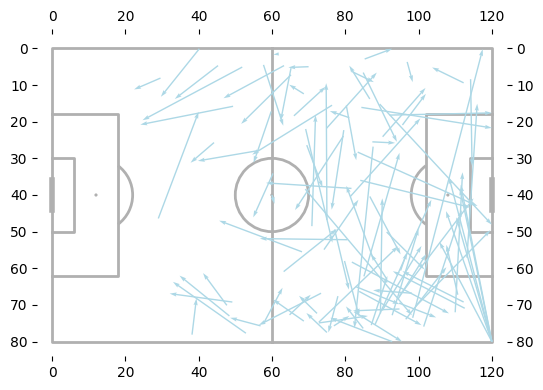

In [29]:
import math
PI = math.pi

def calculate_degree(radiant):
    return (radiant * (180/3.14))

df["degree"] = df["pass_angle"].apply(calculate_degree)

def is_in_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    attacking_third_start = 2 * (pitch_width / 3)
    return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_ball_moving_toward_opponent_goal(angle, tolerance=90):
    """
    Checks if the ball's movement angle (in radians) is within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_ball_moving_vertical(angle, max_tolerance=40):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)

def is_horizontal_pass(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance


def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location) or is_ex_inside_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area


def is_in_edge_of_the_box(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None

# GCA, SCA - passes into penalty area (except corners)
"""
passing = df[df["location"].apply(is_ex_inside_attacking_third) & (df["pass_end_location"].apply(is_in_penalty_area))
             & (df["pass_type"] != "Corner")]


# GCA - low horizontal passes into penalty area (except corners)

passing = df.loc[df["pass_angle"].apply(is_horizontal_pass) & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - low vertical passes into penalty area (except corners)


passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_ex_inside_attacking_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area))) & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from middle third into penalty area   (except corners)
passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_in_middle_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from mid third   
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & 
              (df["location"].apply(is_in_middle_third)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass from defending third
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30))
                 & (df["location"].apply(is_in_defending_third)) 
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30)) 
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - flanke/high/chip horizontal passes into penalty area (except corners) 
passing = df.loc[ (df["pass_angle"].apply(is_horizontal_pass))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]


# GCA - high chip vertical passes into penalty area (except corners) # (( df["degree"] >= (-50) )  & (df["degree"] <= (50)))
passing = df.loc[ (df["pass_angle"].apply(is_ball_moving_vertical))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]

# GCA, SCA - flat Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner") & (df["pass_height"] == "Ground Pass") , :]

# GCA, SCA - general Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner"), :]

# defensive pass                 
passing = df.loc[(df["pass_angle"].apply(is_backward_pass)) &  ~(df["location"].apply(is_in_attacking_third)) 
& (df["pass_type"] != "Corner"), :]

# low vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "Ground Pass"), :]


# high chip vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "High Pass"), :]


# cut_back_into_edge_of_the_box 
passing = df.loc[(df["pass_cut_back"] == True) & (df["pass_end_location"].apply(is_in_edge_of_the_box)), :] # (df["pass_cut_back"] == True) 

# GCA - pass that cuts last line of defence completed
passing = df.loc[ (df["pass_technique"] == "Through Ball") &  df['pass_outcome'].isna(), :]

# GCA - deep (long) low vertical pass from middle third into penalty area   (except corners)
passing = df.loc[ (df["pass_technique"] == "Inswinging") , :]

"""
def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    if isinstance(location, str):
            location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

import matplotlib.pyplot as plt
# passing = df.loc[df["pass_angle"].apply(is_horizontal_pass) & (df["location"].apply(is_ex_inside_attacking_third)) 
#                  & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
#                  & (df["pass_height"] == "Ground Pass"), :]


passing = df.loc[(df["player"] == "Kevin De Bruyne"), : ]

start_location = np.vstack([passing["x"], passing["y"]]).T
end_location = np.vstack([passing["x_end_pass"], passing["y_end_pass"]]).T


# Calculate the change in x and y (vector direction)
dx = end_location[:, 0] - start_location[:, 0]  # difference in x (end_x - start_x)
dy = end_location[:, 1] - start_location[:, 1]  # difference in y (end_y - start_y)

# Draw pitch
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

# Plot arrows using ax.quiver (from start_location to end_location)

pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
             ,ax=ax, width=1, zorder=2,color='lightblue')
"""ax.quiver(
    start_location[:, 0], start_location[:, 1],  # starting points (x, y)
    dx, dy,  # vector components (dx, dy)
    color='lightblue', scale_units='xy', angles='xy', scale=1, width=0.003, headlength=5, headwidth=5, zorder=5
)"""

plt.show()

thoughts:
- horizontal passes in middle third are not progressive or gca
- horizontal passes into final third are progressive and gca
- vertical passes into final third are progressive and gca
- vertical passes into the box are progressicve and gca
- short passes in corner area are not progressive and not gca

In [31]:
df

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,x,y,x_end_pass,y_end_pass,degree
6,Mark Uth,"[61.0, 40.1]",False,<NA>,-1.919567,<NA>,Left Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,Kick Off,NaN,61.0,40.1,60.2,37.9,-110.038892
7,Andrej Kramarić,"[59.4, 38.3]",False,<NA>,2.536994,<NA>,Left Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,59.4,38.3,53.9,42.1,145.432776
8,Sebastian Rudy,"[52.3, 45.2]",False,<NA>,2.390664,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,52.3,45.2,34.3,62.0,137.044412
9,Fabian Lukas Schär,"[34.3, 61.9]",False,<NA>,-1.487222,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,34.3,61.9,37.5,23.7,-85.254755
10,Tobias Strobl,"[38.5, 22.2]",False,<NA>,1.705317,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,38.5,22.2,36.7,35.5,97.757047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067213,Mario Götze,"[84.1, 32.2]",False,<NA>,1.710505,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,Recovery,NaN,84.1,32.2,83.2,38.6,98.054441
1067214,Douglas Costa de Souza,"[86.1, 41.3]",True,<NA>,0.819867,d88c75fa-08a5-4618-b3c2-f92292a6a559,Left Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,86.1,41.3,90.3,45.8,46.998760
1067215,René Adler,"[7.0, 36.1]",False,<NA>,-0.005102,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,Goal Kick,NaN,7.0,36.1,85.4,35.7,-0.292471
1067216,Jérôme Boateng,"[34.7, 44.4]",False,<NA>,-2.840672,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,Recovery,NaN,34.7,44.4,11.5,37.2,-162.841098


In [30]:
passing

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,x,y,x_end_pass,y_end_pass,degree
1024389,Kevin De Bruyne,"[82.9, 65.0]",False,<NA>,0.383401,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,82.9,65.0,94.8,69.8,21.978386
1024391,Kevin De Bruyne,"[68.2, 55.5]",True,<NA>,-2.781852,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,Recovery,NaN,68.2,55.5,45.6,47.0,-159.469251
1024394,Kevin De Bruyne,"[56.2, 27.9]",False,<NA>,2.972492,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,56.2,27.9,39.8,30.7,170.397602
1024412,Kevin De Bruyne,"[86.7, 13.8]",True,<NA>,-2.122451,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,86.7,13.8,81.1,4.7,-121.669183
1024426,Kevin De Bruyne,"[60.3, 34.1]",False,<NA>,1.993650,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,60.3,34.1,54.9,46.1,114.285680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041015,Kevin De Bruyne,"[48.4, 73.0]",False,<NA>,-2.461495,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,48.4,73.0,34.8,62.0,-141.104791
1041040,Kevin De Bruyne,"[29.0, 46.4]",False,<NA>,-1.209392,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,29.0,46.4,40.0,17.3,-69.328208
1041086,Kevin De Bruyne,"[72.3, 72.3]",False,<NA>,-2.366503,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,72.3,72.3,67.4,67.5,-135.659435
1041094,Kevin De Bruyne,"[89.6, 72.3]",False,<NA>,-1.554874,<NA>,Right Foot,<NA>,<NA>,<NA>,...,<NA>,NaN,<NA>,NaN,NaN,89.6,72.3,90.1,40.9,-89.132908
